## NLP

I am classifying Reddit posts as either scientific explanations from "AskScience" or simplified explanations from "explainlikeimfive" based on the language used in the posts. By discerning complex and layman questions, these models aim to enhance the user experience by facilitating access to information in users' preferred level of detail. This differentiation will benefit businesses by enabling personalized content delivery and improved customer support based on users' information needs and understanding.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
df_ELIF = pd.concat([
    pd.read_csv('data/ELIF_06-14-23_20-33.csv'),
    pd.read_csv('data/ELIF_06-15-23_07-28.csv'),
    pd.read_csv('data/ELIF_06-15-23_19-08.csv')
])

In [3]:
df_ELIF['sub'] = 1

In [4]:
df_ELIF.shape

(9623, 6)

In [5]:
df_ELIF.drop_duplicates().shape

(5765, 6)

In [6]:
df_ELIF = df_ELIF.drop_duplicates()

In [7]:
df_ELIF.head()

,time,title,text,upvotes,comments,sub
0,1.686799e+09,"ELI5: What exactly is Mastodon, Misskey, Lemmy...",I’ve heard a lot of people talk about joining ...,0.50,0,1
1,1.686799e+09,eli5: Would you still feel pain when paralyzed?,If you get shot in the spine and instantly bec...,1.00,0,1
2,1.686798e+09,ELI5 Someone else’s POV,I am curious on how other people experience pu...,1.00,1,1
3,1.686797e+09,"Eli5: Practically speaking, how is praxeology ...",Whenever I read or hear that a “praxeology is ...,0.67,2,1
4,1.686796e+09,ELI5: How does an open collector output work?,I've done some reading and it seems like essen...,0.50,2,1


In [8]:
df_AS = pd.concat([
    pd.read_csv('data/AskScience_06-14-23_20-33.csv'),
    pd.read_csv('data/AskScience_06-15-23_07-29.csv'),
    pd.read_csv('data/AskScience_06-15-23_19-09.csv')
])

In [9]:
df_AS['sub'] = 2

In [10]:
df_AS.shape

(10094, 6)

In [11]:
df_AS.drop_duplicates().shape

(5751, 6)

In [12]:
df_AS = df_AS.drop_duplicates()

In [13]:
df_AS.head()

,time,title,text,upvotes,comments,sub
0,1.686763e+09,How does Mercury's orbit prove Einstein's theo...,Hello! Complete science dunce here. I tried to...,0.86,57,2
1,1.686719e+09,When alcohol degreases something where does th...,Is it dissolved and then evaporated along wit...,0.86,167,2
2,1.686716e+09,Is stomach acid a medical concern during injur...,If someone receives a penetrative wound to the...,0.85,62,2
3,1.686544e+09,AskScience’s concerns regarding Reddit’s API c...,"In April 2023, [Reddit announced they would be...",0.89,1,2
4,1.686499e+09,how does hypotension (from spinal anesthesia) ...,specifically how does it cause platelets to be...,0.87,2,2


In [14]:
df = pd.concat([df_ELIF, df_AS])

In [15]:
df.shape

(11516, 6)

In [16]:
df.drop_duplicates().shape

(11516, 6)

In [17]:
df.head()

,time,title,text,upvotes,comments,sub
0,1.686799e+09,"ELI5: What exactly is Mastodon, Misskey, Lemmy...",I’ve heard a lot of people talk about joining ...,0.50,0,1
1,1.686799e+09,eli5: Would you still feel pain when paralyzed?,If you get shot in the spine and instantly bec...,1.00,0,1
2,1.686798e+09,ELI5 Someone else’s POV,I am curious on how other people experience pu...,1.00,1,1
3,1.686797e+09,"Eli5: Practically speaking, how is praxeology ...",Whenever I read or hear that a “praxeology is ...,0.67,2,1
4,1.686796e+09,ELI5: How does an open collector output work?,I've done some reading and it seems like essen...,0.50,2,1


In [18]:
df['sub'].value_counts(normalize = True)

1    0.500608
2    0.499392
Name: sub, dtype: float64

I combined the three scrapes of both subreddits together and dropped their duplicates before concating them into a master dataframe to use for modeling. With scores of 0.500608 for 'ELIF' and 0.499392 for 'AskScience', my data is an even split and I don't need to worry about unbalanced classes.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11516 entries, 0 to 3344
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      11516 non-null  float64
 1   title     11516 non-null  object 
 2   text      7406 non-null   object 
 3   upvotes   11516 non-null  float64
 4   comments  11516 non-null  int64  
 5   sub       11516 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 629.8+ KB


In [20]:
df.describe()

,time,upvotes,comments,sub
count,1.151600e+04,11516.000000,11516.000000,11516.000000
mean,1.592073e+09,0.669978,199.549670,1.499392
std,1.155580e+08,0.182485,480.979233,0.500021
min,1.288380e+09,0.100000,0.000000,1.000000
25%,1.507089e+09,0.520000,7.000000,1.000000
50%,1.661754e+09,0.620000,15.000000,1.000000
75%,1.685214e+09,0.860000,55.000000,2.000000
max,1.686880e+09,1.000000,10687.000000,2.000000


In [21]:
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()

In [22]:
df['title'] = df['title'].str.replace('elif:', '')
df['title'] = df['title'].str.replace('elif-', '')
df['title'] = df['title'].str.replace('elif', '')
df['title'] = df['title'].str.replace('eli5:', '')
df['title'] = df['title'].str.replace('eli5-', '')
df['title'] = df['title'].str.replace('eli5', '')
df['title'] = df['title'].str.replace('askscience ama series:', '')

In [23]:
df.isna().sum()

time           0
title          0
text        4110
upvotes        0
comments       0
sub            0
dtype: int64

In [24]:
df['text'].fillna(df['title'], inplace = True)

In [25]:
df.isna().sum()

time        0
title       0
text        0
upvotes     0
comments    0
sub         0
dtype: int64

The subreddits had certain tags that denoted where they came from, especially for 'ELIF' where nearly every post was tagged with it, due to this I removed these tags. Roughly 4000 missing texts were replaced with the title of the post as the title was there intended question to post. 

In [26]:
df['title_word_count'] = df['title'].str.split(' ').apply(len)
df['text_word_count'] = df['text'].str.split(' ').apply(len)

In [27]:
sia = SentimentIntensityAnalyzer()

In [28]:
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [29]:
df.head(1)

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment
0,1.686799e+09,"what exactly is mastodon, misskey, lemmy and ...",i’ve heard a lot of people talk about joining ...,0.5,0,1,10,32,0.0


I found the word counts for both the title and text. Furthermore, I created a new column for polarity scores which describes the sentiment of the text column.

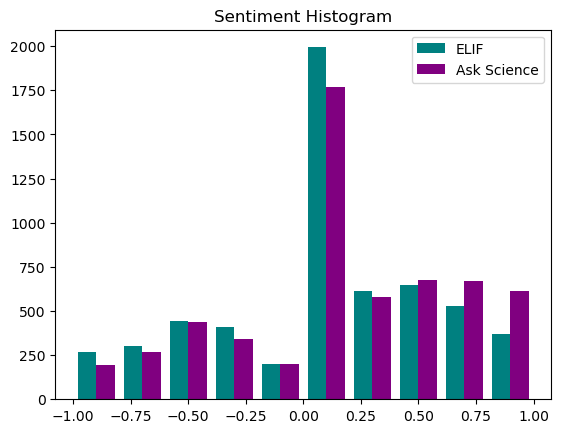

In [30]:
sub1 = df[df['sub'] == 1]['sentiment']
sub2 = df[df['sub'] == 2]['sentiment']
plt.hist([sub1, sub2], color=['teal', 'purple'])
plt.legend(['ELIF', 'Ask Science'])
plt.title('Sentiment Histogram')
plt.savefig('images/Sentiment Histogram.png', dpi = 500);

In [31]:
tokenizer = RegexpTokenizer('\w+')

In [32]:
df['title_tokens'] = df['title'].apply(lambda x: tokenizer.tokenize(x))
df['text_tokens'] = df['text'].apply(lambda x: tokenizer.tokenize(x))

In [33]:
df.head(1)

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment,title_tokens,text_tokens
0,1.686799e+09,"what exactly is mastodon, misskey, lemmy and ...",i’ve heard a lot of people talk about joining ...,0.5,0,1,10,32,0.0,"[what, exactly, is, mastodon, misskey, lemmy, ...","[i, ve, heard, a, lot, of, people, talk, about..."


In [34]:
df['title_tokens'] = df['title_tokens'].apply(lambda x: [token for token in x if token not in stopwords.words('english')])
df['text_tokens'] = df['text_tokens'].apply(lambda x: [token for token in x if token not in stopwords.words('english')])

In [35]:
df.head()

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment,title_tokens,text_tokens
0,1.686799e+09,"what exactly is mastodon, misskey, lemmy and ...",i’ve heard a lot of people talk about joining ...,0.50,0,1,10,32,0.0000,"[exactly, mastodon, misskey, lemmy, fediverse]","[heard, lot, people, talk, joining, mastodon, ..."
1,1.686799e+09,would you still feel pain when paralyzed?,if you get shot in the spine and instantly bec...,1.00,0,1,8,37,-0.7882,"[would, still, feel, pain, paralyzed]","[get, shot, spine, instantly, become, paralyze..."
2,1.686798e+09,someone else’s pov,i am curious on how other people experience pu...,1.00,1,1,4,55,0.9109,"[someone, else, pov]","[curious, people, experience, putting, someone..."
3,1.686797e+09,"practically speaking, how is praxeology diffe...",whenever i read or hear that a “praxeology is ...,0.67,2,1,9,115,0.4832,"[practically, speaking, praxeology, different,...","[whenever, read, hear, praxeology, way, deduce..."
4,1.686796e+09,how does an open collector output work?,i've done some reading and it seems like essen...,0.50,2,1,8,142,0.2937,"[open, collector, output, work]","[done, reading, seems, like, essentially, stra..."


In [36]:
wn = WordNetLemmatizer()
ps = PorterStemmer()

In [37]:
df['title_tokens'] = df['title_tokens'].apply(lambda x: [wn.lemmatize(token) for token in x])
df['title_tokens'] = df['title_tokens'].apply(lambda x: [wn.lemmatize(token) for token in x])

In [38]:
df['title_tokens'] = df['title_tokens'].apply(lambda x: ' '.join([ps.stem(token) for token in x]))
df['text_tokens'] = df['text_tokens'].apply(lambda x: ' '.join([ps.stem(token) for token in x]))

In [39]:
df.head()

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment,title_tokens,text_tokens
0,1.686799e+09,"what exactly is mastodon, misskey, lemmy and ...",i’ve heard a lot of people talk about joining ...,0.50,0,1,10,32,0.0000,exactli mastodon misskey lemmi fedivers,heard lot peopl talk join mastodon especi also...
1,1.686799e+09,would you still feel pain when paralyzed?,if you get shot in the spine and instantly bec...,1.00,0,1,8,37,-0.7882,would still feel pain paralyz,get shot spine instantli becom paralyz neck wo...
2,1.686798e+09,someone else’s pov,i am curious on how other people experience pu...,1.00,1,1,4,55,0.9109,someon els pov,curiou peopl experi put someon els shoe actual...
3,1.686797e+09,"practically speaking, how is praxeology diffe...",whenever i read or hear that a “praxeology is ...,0.67,2,1,9,115,0.4832,practic speak praxeolog differ psycholog,whenev read hear praxeolog way deduc behavior ...
4,1.686796e+09,how does an open collector output work?,i've done some reading and it seems like essen...,0.50,2,1,8,142,0.2937,open collector output work,done read seem like essenti strang devic work ...


I tokenized, stemmed, lemmed, and removed stop words both for the title and text columns and created their own respective columns to make it easier for machine learning models to predict the origin of their subreddit.

In [40]:
cvec = CountVectorizer()
X = cvec.fit_transform(df['text_tokens'])

In [41]:
df_cvec = pd.DataFrame(X.toarray(), columns = cvec.get_feature_names_out())

In [42]:
df_cvec.head()

,00,000,0000,0001,0004,0006849315,00090,000km,001,003,...,zooid,zoom,zoomer,zoonot,zw0pht47aau,zwq0591paxm,zxa_yreef,ʔaˈmaːn,ˈʕaːnxu,ꜥnḫ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


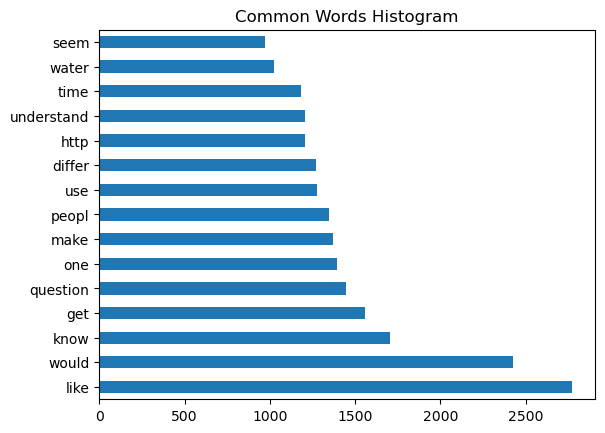

In [43]:
df_cvec.sum().sort_values(ascending=False).head(15).plot(kind = 'barh')
plt.title('Common Words Histogram')
plt.savefig('images/Common Words Histogram.png', dpi = 500);

In [44]:
df[df['text_tokens'].str.contains('http', case = False)].head()

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment,title_tokens,text_tokens
24,1.686765e+09,how are popsicles made?,i obviously get that it is just frozen liquid ...,0.33,6,1,5,22,0.5719,popsicl made,obvious get frozen liquid design format ice ma...
52,1.686740e+09,- how is incommensurability a thing?,i was watching [this video](https://youtu.be/e...,0.71,7,1,7,189,-0.8581,incommensur thing,watch video http youtu eue7pp_rufk youtub inco...
71,1.686599e+09,why are so many subreddits “going dark”?,update: the eli5 subreddit is back up for busi...,0.77,2511,1,8,1438,0.9990,mani subreddit go dark,updat eli5 subreddit back busi leav current st...
82,1.686502e+09,the dividend discount model,i will preface this to say that yes of course ...,0.60,26,1,5,162,0.9594,dividend discount model,prefac say ye cours research face hour equat e...
107,1.686452e+09,what does a scientist mean when she say ““it’...,i was reading an article on the discovery of s...,0.71,15,1,18,71,0.5499,scientist mean say rare nowaday fundament disc...,read articl discoveri salti ice may present ex...


In [45]:
df

,time,title,text,upvotes,comments,sub,title_word_count,text_word_count,sentiment,title_tokens,text_tokens
0,1.686799e+09,"what exactly is mastodon, misskey, lemmy and ...",i’ve heard a lot of people talk about joining ...,0.50,0,1,10,32,0.0000,exactli mastodon misskey lemmi fedivers,heard lot peopl talk join mastodon especi also...
1,1.686799e+09,would you still feel pain when paralyzed?,if you get shot in the spine and instantly bec...,1.00,0,1,8,37,-0.7882,would still feel pain paralyz,get shot spine instantli becom paralyz neck wo...
2,1.686798e+09,someone else’s pov,i am curious on how other people experience pu...,1.00,1,1,4,55,0.9109,someon els pov,curiou peopl experi put someon els shoe actual...
3,1.686797e+09,"practically speaking, how is praxeology diffe...",whenever i read or hear that a “praxeology is ...,0.67,2,1,9,115,0.4832,practic speak praxeolog differ psycholog,whenev read hear praxeolog way deduc behavior ...
4,1.686796e+09,how does an open collector output work?,i've done some reading and it seems like essen...,0.50,2,1,8,142,0.2937,open collector output work,done read seem like essenti strang devic work ...
...,...,...,...,...,...,...,...,...,...,...,...
3336,1.415343e+09,do the photons in moonlight originate from the...,do the photons that constitute moonlight origi...,0.53,7,2,15,39,0.0000,photon moonlight origin sun reflect moon fluoresc,photon constitut moonlight origin sun bounc lu...
3337,1.413818e+09,why do electrons have -1 charge and not a +1 c...,i'm currently studying chemistry and although ...,0.47,7,2,11,168,-0.8698,electron 1 charg 1 charg,current studi chemistri although done read phy...
3340,1.406395e+09,"at the center of the earth, wouldn't there exi...",maybe this should be posted in shower thoughts...,0.44,6,2,45,18,0.5023,center earth exist heaviest dens element never...,mayb post shower thought like get scientif opi...
3341,1.401026e+09,[physics] how does an eigenstate related to an...,i'm getting really jumbled up in all this eige...,0.50,7,2,9,69,0.4402,physic eigenst relat eigenvector,get realli jumbl eigen terminolog find realli ...


Originally, I planned to add common words into my stop words list but after much condiseration and early testing, it looks as if the full unedited post is doing better for my model as the goal here is to determine between complex and layman questions and removing stop words is taking away too much context.

In [46]:
df.to_csv('data/master.csv', index = False)